# ToffoliゲートとShorコード

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$

量子プログラミング演習として、Toffoliゲートの基本ゲートでの分解を考え、それを使ってShorコードでエラー訂正をしてみましょう。

## 量子エラー訂正

IBMQをはじめ、私たちが現在利用できる量子コンピュータは NISQ (Noisy, intermediate-scale quantum) デバイスと呼ばれ、計算途中にエラーが起こるとそこから回復することができません。エラーが量子回路の実行時間やゲート数の増加とともに重なる様子は、すでに講義に出てきたさまざまな例で観察いただけたと思います。量子コンピュータがクラウド上で使えると言っても結局まともな計算はできない、という印象を持たれた方も多いかと思います。じっさい、NISQの最も現実的な使い道は、Shorの素因数分解アルゴリズムなどの「真の」量子計算ではなく、VQEなどの量子・古典ハイブリッド計算で、ゲート数が少なく、かつ多少間違えが起きても最終的な結果に大きく影響しないようなものだと考えられています。

では、真の量子計算ができるようになる条件とは何でしょうか。エラーが起こらない量子コンピュータを作ること、という答えは当然考えられますが、これは原理的に不可能です。なぜなら、量子コンピュータにおけるエラーとはすなわち量子ビットに外部環境が影響を及ぼすことであり、
エラーが起こらない ＝ 量子ビットが完全に孤立した系にある
となるわけですが、一方で、
量子ビットをコンピュータとして使える ＝ 量子ビットを外部から操作できる ＝ 量子ビットは孤立していない
も言えるからです。

次に考えられるのは、エラーの発生率を極力低くして、エラーが発生する前に全ての計算を終えること（NISQの延長）ですが、例えば2048ビットの整数の素因数分解をエラーなしで完遂するには、エラー率が$10^{-8}$よりもはるかに低くないといけません。現在のマシンのエラー率が$10^{-2}$から$10^{-3}$程度なので、これはあまり現実的なゴールではありません。また、そもそもエラーは確率的に起こるので、どんなに短い回路でもエラーが乗ることはありえます。

実は、難しそうに見えて一番実現可能性があるのが、**計算途中にエラーが起きたとき、それを検知して訂正すること**です。回路の実行中にリアルタイムでエラー訂正が行えれば、訂正のための様々なコスト（追加の量子ビットやゲート）はあるものの、計算結果だけを見ればエラーのない理想的な量子コンピュータを使うのと同じものが得られます。そのような量子コンピュータは FTQC (Fault-tolerant quantum computers) と呼ばれ、NISQとは質的に異なるものとみなされています。

エラーというのはノイズなどコントロールできない要因でランダムに発生するものなので、量子エラー訂正が可能であるということ自体が非自明で驚くべき事実です。その背景には量子力学の原理があり、どんなエラーも、量子ビットへの影響だけを見れば、有限の量子演算子の組み合わせがかかるのと等価であるということが示されています。したがって、それらの影響を検知し打ち消すような量子回路を組むことができれば、エラー訂正が実現されます。

量子エラー訂正については古くから研究がなされており、すでに複数の方法が知られています。それでもまだFTQCが実現されていないのは、エラー訂正自体に多数の量子ビットが必要である上に、絶対的なエラー率が一定値以下でなければいけないからです。エラーが訂正できると言っても、訂正するための回路自体がエラーでデタラメになってしまうようでは元も子もないので、やはりある程度の安定性が必要なのです。しかし逆に、それぞれのエラー訂正プロトコルについて、求められるエラー率の上限値が存在することが知られています。つまり、エラー率がどこまでも低くなければいけないということはなく、一定値以下であればエラー訂正を繰り返して任意の長さの量子回路を実行できるということです。これをエラー率の「閾値定理」といい、エラーの種類が有限であるという事実と合わせて、エラー訂正というアプローチの強力な下支えになっています。

一般にエラー訂正をするには、個々の量子ビットの状態を、複数のエンタングルした量子ビットの状態に「エンコード」します。エンコーディングの結果生じる、1量子ビット分の情報を保持する複数量子ビットのまとまりを**論理量子ビット**と呼び、論理量子ビットから元の（物理的）量子ビットの状態を復元することをデコーディングと呼びます。特定のエラーに対して耐性がある（エラーの補正を可能にする）論理量子ビットの組み方のことをエラー訂正コードと言います。論理量子ビットに対して論理ゲートや論理測定を考えることができるので、FTQCでの量子計算の最小単位は、何らかのエラー訂正コードで作られた論理量子ビットとなると考えられています。

エラー訂正は奥の深い研究領域ですが、今回の演習では本格的な話はせず、比較的単純な「Shorコード」というエラー訂正コードの実装だけを考えます。Shorコードは素因数分解のアルゴリズムを発案したPeter Shorのもう一つの重要な発明で、最初に実現されるFTQCで採用されるプロトコルの有力候補ではありませんが、エラー訂正という手法を理解するのにとても役に立ちます。

## Toffoliゲート

Shorコードやそのベースとなるビット反転・位相反転コードのデコーディングで欠かせないのがToffoliゲート(CCX)です。

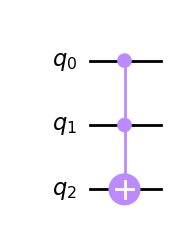

In [1]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(3)
circuit.ccx(0, 1, 2)
circuit.draw('mpl')

Toffoliゲートはエラー訂正だけでなく、多重制御ゲートの基本パーツとなるため、さまざまな場面で登場します。また理論的には、ToffoliゲートとHadamardゲートの組み合わせで全ての量子演算が実現できる（普遍ゲートセットとなる）ことから、Toffoliゲートは特別重要な存在です。

一見単純そうに見えるToffoliゲートですが、超伝導量子回路などの実機で、基本ゲートが1量子ビットゲートと2量子ビットゲートのみからなる（IBMのケースでは$X$, $\sqrt{X}$, $R_z$, CX）場合、実装（基本ゲートへの分解）は非自明です。これから、Toffoliゲートの一つの分解方法をステップごとに導いてみましょう。

In [2]:
# まずは必要なモジュールをインポートする
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info.operators import Operator
from IPython.display import Latex

from qc_workbook.show_state import show_state, statevector_expr

In [3]:
def show_circuit_op(circuit, global_phase=0.):
    """Compiles the LaTeX expression of the operation of the circuit on computational basis states."""

    op = Operator(circuit)

    unitary = op.data * np.exp(-1.j * global_phase)

    ket_template = fr'|{{:0{circuit.num_qubits}b}}\rangle'

    exprs = list()
    for icol, col in enumerate(unitary.T):
        expr = statevector_expr(col, binary=True, state_label=None)
        exprs.append(fr'{ket_template.format(icol)} & \rightarrow {expr}')

    return Latex(r'\begin{align} ' + r' \\ '.join(exprs) + r' \end{align}')

## CPゲート

最初の問題は、制御$P$（$CP$）ゲートをCXと$R_z$から作ることです。おさらいをすると、CPゲートとは、2量子ビットゲートで、パラメータ$\phi$を取り、二つの量子ビットがともに$\ket{1}$であるような計算基底の位相を$\phi$前進させるゲートのことでした。

```{math}
    CP(\phi) \ket{00} & = \ket{00} \\
    CP(\phi) \ket{01} & = \ket{01} \\
    CP(\phi) \ket{10} & = \ket{10} \\
    CP(\phi) \ket{11} & = e^{i\phi} \ket{11}
```

**ヒント1**

まず制御$R_z$（$CR_z$）ゲートをCXと$R_z$から作ることを考えてみましょう。$CR_z$の作用は、左を制御ビット、右を標的ビットとして

```{math}
    CR_z(\phi) \ket{00} & = \ket{00} \\
    CR_z(\phi) \ket{01} & = \ket{01} \\
    CR_z(\phi) \ket{10} & = e^{-i\phi/2} \ket{10} \\
    CR_z(\phi) \ket{11} & = e^{i\phi/2} \ket{11}
```

です。$CR_z$が作れれば、制御ビットに$R_z$をかけることで、$\ket{00}, \ket{01}, \ket{10}$の位相を揃えることができ、$CP$ゲートに全体位相がかかった状態が実現できます。全体位相は無視していいので、それで$CP$ゲートの完成です。

**ヒント2**

$R_z$を$X$で挟むと、$R_z$のパラメータの符号を反転させたのと同じ作用が得られます。

```{image} figs/rz_x_rz_x.png
:alt: rz_x_rz_x
:width: 400px
:align: center
```

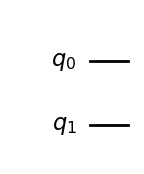

In [4]:
cp_circuit = QuantumCircuit(2, name='CP')

phi = Parameter('$\phi$')

# cp_circuit が CP(phi)を実装するようにゲートを加えてください。
# phiは普通の変数のように使えます。
# 例： cp_circuit.rz(phi, 1)

##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

cp_circuit.draw('mpl')

In [5]:
# phiに具体的な値を入れて、CPが実装されていることを確認
phi_value = np.pi / 4.
show_circuit_op(cp_circuit.bind_parameters({phi: phi_value}), global_phase=(-phi_value / 4.))

CircuitError: 'Cannot bind parameters ($\\phi$) not present in the circuit.'

$CP$は`QuantumCircuit`オブジェクトにもメソッド`cp`として備わっているので、以下では（回路図の見やすさを考慮して）標準メソッドを使うことにします。

## CCZゲート

次に、$CP$ゲートの特殊ケース（$\phi=\pi$）である制御$Z$（CZ）ゲートを二重制御に拡張したCCZゲートを、$CP$とCXを組み合わせて実装します。

```{math}
    \text{CCZ} \ket{k} & = \ket{k} \; \text{for}\; 000 \leq k \leq 110 \\
    \text{CCZ} \ket{111} & = -\ket{111}
```

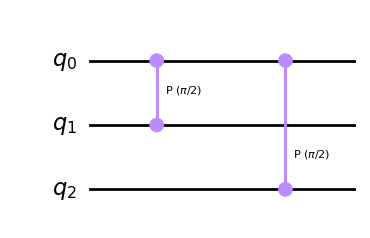

In [6]:
ccz_circuit = QuantumCircuit(3, name='CCZ')

# ccz_circuit が CCZを実装するようにゲートを加えてください。

ccz_circuit.cp(np.pi / 2., 1, 0)
ccz_circuit.cp(np.pi / 2., 2, 0)

# 上の二行で|111>の符号が反転しますが、同時に|011>と|101>の符号も変わってしまうので、それを訂正する方法を考えてください。

##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

ccz_circuit.draw('mpl')

In [7]:
show_circuit_op(ccz_circuit)

<IPython.core.display.Latex object>

## Hadamardゲート

次にHadamardゲートの$R_z$と$\sqrt{X}$への分解を考えます。$\sqrt{X}$の作用は

```{math}
    \sqrt{X} \ket{0} & = \frac{1}{\sqrt{2}} \left[e^{\frac{\pi}{4}i} \ket{0} + e^{-i\frac{\pi}{4}} \ket{1}\right] \\
    \sqrt{X} \ket{1} & = \frac{1}{\sqrt{2}} \left[e^{-\frac{\pi}{4}i} \ket{0} + e^{i\frac{\pi}{4}} \ket{1}\right]
```

です。

**ヒント**

$R_z(\phi)\ket{0}$や$R_z(\phi)\ket{1}$に$\sqrt{X}$をかけるとどうなるか、また$\sqrt{X}$をかけた後の状態に$R_z(\phi)$をかけたらどうなるか、計算してみましょう。今回も全体位相が生じます。

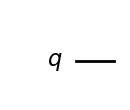

In [8]:
h_circuit = QuantumCircuit(1, name='H')

# h_circuit が Hを実装するようにゲートを加えてください。

##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

h_circuit.draw('mpl')

In [9]:
show_circuit_op(h_circuit, global_phase=(-1. / 4. * np.pi))

<IPython.core.display.Latex object>

## Toffoliゲート

$Z$ゲートを$H$ゲートで挟むと$X$ゲートと等価になることを思い出して、CCZと$H$からCCXを作ってください。

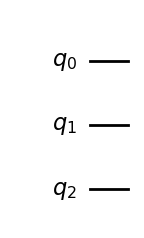

In [10]:
toffoli_circuit = QuantumCircuit(3, name='Toffoli')

# toffoli_circuit が Toffoliを実装するようにゲートを加えてください。
# 量子ビット0が標的、1と2が制御とします。
# Hadamardゲートには toffoli_circuit.h()を使って構いません。

##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

toffoli_circuit.draw('mpl')

In [11]:
show_circuit_op(toffoli_circuit)

<IPython.core.display.Latex object>

## 量子エラーとエラー訂正

冒頭で述べたように、量子エラーは有限個の量子演算子の作用として捉えることができます。特に、1量子ビットのエラーは、量子ビットに$X$、$Z$、$XZ$のどれかがかかることと等価です。$X$がかかるようなエラーをビット反転（bit flip）エラー、$Z$のケースを位相反転（phase flip）エラー、$XZ$のケースを複合（combined bit-phase flip）エラーと呼びます。

### ビット反転（$X$）エラー

Shorコードの元になるのはビット反転コードという、量子ビットを3つ使うエラー訂正コードです。ビット反転コードは、その名が示唆するようにビット反転エラーに対してのみ耐性を持ちます。論理量子ビットでの計算途中で3つの量子ビットのうちのどれかにビット反転エラーが一度だけ起きるとき、デコーディングの過程でエラーが補正されます。

ビット反転コードのエンコーディングは

```{math}
    \ket{0_L} & = \ket{000} \\
    \ket{1_L} & = \ket{111}
```

です。ここで$\ket{0_L}$と$\ket{1_L}$はそれぞれ「論理$\ket{0}$状態」と「論理$\ket{1}$状態」を表します。

以下では、適当な状態に初期化した量子ビットをビット反転コードでエンコードし、論理量子ビットに論理$Z$ゲートをかける過程でどれかひとつの（物理）量子ビットにビット反転エラーが起きるというシナリオを考えます。デコーディングの際にToffoliゲートを使うと、エラーが補正されます。

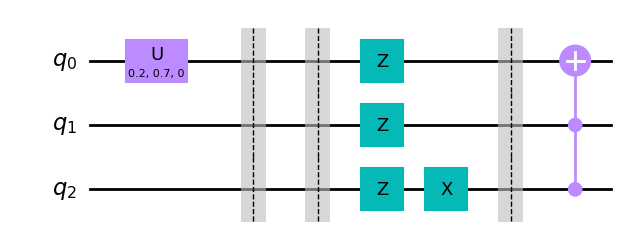

In [12]:
bitflip_circuit = QuantumCircuit(3)

# データ量子ビット（第0ビット）を適当な状態に初期化
bitflip_circuit.u(0.2, 0.7, 0., 0)
bitflip_circuit.barrier()

# データビットの|0>が|000>に、|1>が|111>にエンコードされるように量子ビットをエンタングルさせてください
##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

bitflip_circuit.barrier()

# 論理ZゲートはZZZ
bitflip_circuit.z([0, 1, 2])

# 0から2のどれかひとつの量子ビットにX（ビット反転）がかかる
bitflip_circuit.x(np.random.randint(3))

bitflip_circuit.barrier()

# デコーディング：状態が|000>, |001>, |010>, |100>のときデータビットが|0>になり、
# |111>, |110>, |101>, |011>のとき|1>になるようにCXとToffoliを組んでください（Toffoliはすでに書き込んであります）
##################
### EDIT BELOW ###
##################

...

# 0が標的、1と2が制御
bitflip_circuit.ccx(1, 2, 0)

##################
### EDIT ABOVE ###
##################

bitflip_circuit.draw('mpl')

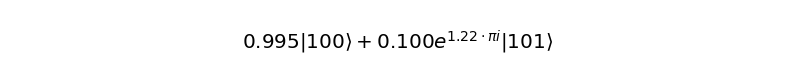

In [13]:
show_state(bitflip_circuit, binary=True);

第1と第2量子ビット（Qiskitの順番なので左二桁）の状態が同一である＝第3量子ビットとのエンタングルメントが切れていれば、正しくデコードされています。第0ビットの状態をエラーのない単一量子ビット回路のものと比較します。

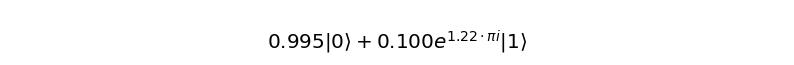

In [14]:
ref_circuit = QuantumCircuit(1)

ref_circuit.u(0.2, 0.7, 0., 0)
ref_circuit.z(0)
show_state(ref_circuit, binary=True);

### 位相反転（$Z$）エラー

次に、位相反転に対してのみ耐性を持つ3量子ビットのエラー訂正コードを考えます。$Z$を$H$で挟むと$X$になることを思い出すと、ビット反転コードを転用できることがすぐにわかります。

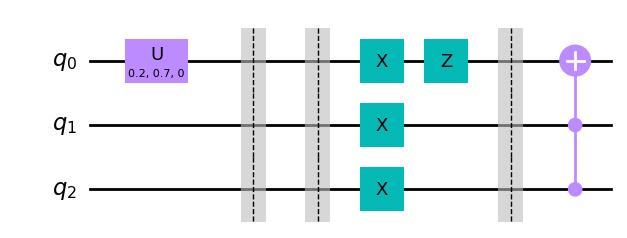

In [15]:
phaseflip_circuit = QuantumCircuit(3)

phaseflip_circuit.u(0.2, 0.7, 0., 0)
phaseflip_circuit.barrier()

# エンコーディング
##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

phaseflip_circuit.barrier()

# 位相反転コードの論理ZゲートはXXX
phaseflip_circuit.x([0, 1, 2])

# ランダムに位相反転エラーが発生
phaseflip_circuit.z(np.random.randint(3))

phaseflip_circuit.barrier()

# デコーディング
##################
### EDIT BELOW ###
##################

...

phaseflip_circuit.ccx(1, 2, 0)

##################
### EDIT ABOVE ###
##################

phaseflip_circuit.draw('mpl')

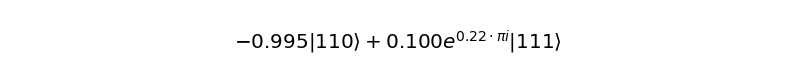

In [16]:
show_state(phaseflip_circuit, binary=True);

### Shorコード

Shorコードは位相反転コードの物理量子ビットにビット反転コードの論理量子ビットを使って作ります。全部で9つの量子ビットを使い、全ての1量子ビットエラー（$X, Z, XZ$）に耐性を持ちます。

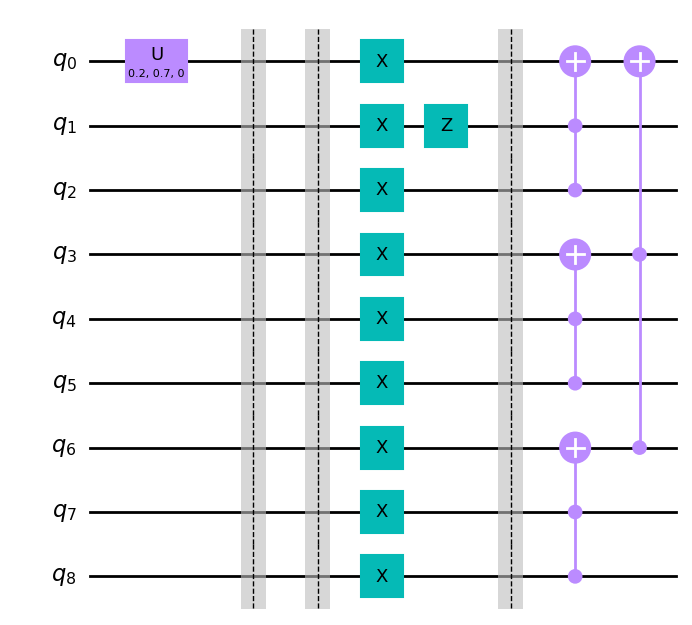

In [17]:
shor_circuit = QuantumCircuit(9)

shor_circuit.u(0.2, 0.7, 0., 0)
shor_circuit.barrier()

# エンコーディング
##################
### EDIT BELOW ###
##################

##################
### EDIT ABOVE ###
##################

shor_circuit.barrier()

# Shorコードの論理ZゲートもXXXXXXXXX
shor_circuit.x(range(9))

# ランダムにビットと位相が反転
erroneous_qubit = np.random.randint(9)
error = np.random.choice(['x', 'z', 'xz'])
if 'x' in error:
    shor_circuit.x(erroneous_qubit)
if 'z' in error:
    shor_circuit.z(erroneous_qubit)

shor_circuit.barrier()

# デコーディング
##################
### EDIT BELOW ###
##################

...

# ビット反転補正のためのToffoli
for itarg in [0, 3, 6]:
    shor_circuit.ccx(itarg + 1, itarg + 2, itarg)

...

# 位相反転補正のためのToffoli
shor_circuit.ccx(3, 6, 0)

##################
### EDIT ABOVE ###
##################

shor_circuit.draw('mpl')

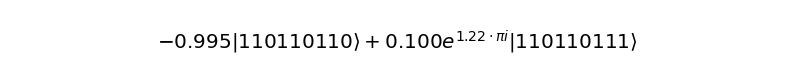

In [18]:
if error == 'xz':
    global_phase = -np.pi
else:
    global_phase = 0.

show_state(shor_circuit, global_phase=global_phase, binary=True);